In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import keras
import keras.backend as K
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Using TensorFlow backend.


Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9653577912402896250, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8352043089021938787
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline


from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers.core import Dropout, Dense
from keras.models import Model, load_model
from keras.initializers import he_normal, glorot_normal
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


from keras.regularizers import l2

In [5]:
output_classes = 2
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 50

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [6]:
train_dir = 'data/train/'
validation_dir = 'data/validation'
test_dir = 'data/test2'

In [7]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/train/ 0
data/train/malignant 40424
data/train/normal 18744
******************************
data/validation 0
data/validation\malignant 12512
data/validation\normal 5872
******************************
data/test2 0
data/test2\malignant 655
data/test2\normal 312


In [8]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59168 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [19]:
from keras import backend as K
# from keras.applications.imagenet_utils import _obtain_input_shape
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.layers import Activation, Add, Concatenate, GlobalAveragePooling2D,GlobalMaxPooling2D, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda
# from keras.applications.mobilenet import DepthwiseConv2D
from keras.layers import DepthwiseConv2D
import numpy as np


def ShuffleNet(include_top=True, input_tensor=None, scale_factor=1.0, pooling='max',
               input_shape=(224,224,3), groups=1, load_model=None, num_shuffle_units=[3, 7, 3],
               bottleneck_ratio=0.25, classes=1000):
    """
    ShuffleNet implementation for Keras 2
    ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices
    Xiangyu Zhang, Xinyu Zhou, Mengxiao Lin, Jian Sun
    https://arxiv.org/pdf/1707.01083.pdf
    Note that only TensorFlow is supported for now, therefore it only works
    with the data format `image_data_format='channels_last'` in your Keras
    config at `~/.keras/keras.json`.
    Parameters
    ----------
    include_top: bool(True)
         whether to include the fully-connected layer at the top of the network.
    input_tensor:
        optional Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
    scale_factor:
        scales the number of output channels
    input_shape:
    pooling:
        Optional pooling mode for feature extraction
        when `include_top` is `False`.
        - `None` means that the output of the model
            will be the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a
            2D tensor.
        - `max` means that global max pooling will
            be applied.
    groups: int
        number of groups per channel
    num_shuffle_units: list([3,7,3])
        number of stages (list length) and the number of shufflenet units in a
        stage beginning with stage 2 because stage 1 is fixed
        e.g. idx 0 contains 3 + 1 (first shuffle unit in each stage differs) shufflenet units for stage 2
        idx 1 contains 7 + 1 Shufflenet Units for stage 3 and
        idx 2 contains 3 + 1 Shufflenet Units
    bottleneck_ratio:
        bottleneck ratio implies the ratio of bottleneck channels to output channels.
        For example, bottleneck ratio = 1 : 4 means the output feature map is 4 times
        the width of the bottleneck feature map.
    classes: int(1000)
        number of classes to predict
    Returns
    -------
        A Keras model instance
    References
    ----------
    - [ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices]
      (http://www.arxiv.org/pdf/1707.01083.pdf)
    """

    if K.backend() != 'tensorflow':
        raise RuntimeError('Only TensorFlow backend is currently supported, '
                           'as other backends do not support ')

    name = "ShuffleNet_%.2gX_g%d_br_%.2g_%s" % (scale_factor, groups, bottleneck_ratio, "".join([str(x) for x in num_shuffle_units]))

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=28,
                                      require_flatten=include_top,
                                      data_format=K.image_data_format())

    out_dim_stage_two = {1: 144, 2: 200, 3: 240, 4: 272, 8: 384}
    if groups not in out_dim_stage_two:
        raise ValueError("Invalid number of groups.")

    if pooling not in ['max','avg']:
        raise ValueError("Invalid value for pooling.")

    if not (float(scale_factor) * 4).is_integer():
        raise ValueError("Invalid value for scale_factor. Should be x over 4.")

    exp = np.insert(np.arange(0, len(num_shuffle_units), dtype=np.float32), 0, 0)
    out_channels_in_stage = 2 ** exp
    out_channels_in_stage *= out_dim_stage_two[groups]  # calculate output channels for each stage
    out_channels_in_stage[0] = 24  # first stage has always 24 output channels
    out_channels_in_stage *= scale_factor
    out_channels_in_stage = out_channels_in_stage.astype(int)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # create shufflenet architecture
    x = Conv2D(filters=out_channels_in_stage[0], kernel_size=(3, 3), padding='same',
               use_bias=False, strides=(2, 2), activation="relu", name="conv1")(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="maxpool1")(x)

    # create stages containing shufflenet units beginning at stage 2
    for stage in range(0, len(num_shuffle_units)):
        repeat = num_shuffle_units[stage]
        x = _block(x, out_channels_in_stage, repeat=repeat,
                   bottleneck_ratio=bottleneck_ratio,
                   groups=groups, stage=stage + 2)

    if pooling == 'avg':
        x = GlobalAveragePooling2D(name="global_pool")(x)
    elif pooling == 'max':
        x = GlobalMaxPooling2D(name="global_pool")(x)

    if include_top:
        x = Dense(units=classes, name="fc")(x)
        x = Activation('softmax', name='softmax')(x)


    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs=inputs, outputs=x, name=name)

    if load_model is not None:
        model.load_weights('', by_name=True)

    return model


def _block(x, channel_map, bottleneck_ratio, repeat=1, groups=1, stage=1):
    """
    creates a bottleneck block containing `repeat + 1` shuffle units
    Parameters
    ----------
    x:
        Input tensor of with `channels_last` data format
    channel_map: list
        list containing the number of output channels for a stage
    repeat: int(1)
        number of repetitions for a shuffle unit with stride 1
    groups: int(1)
        number of groups per channel
    bottleneck_ratio: float
        bottleneck ratio implies the ratio of bottleneck channels to output channels.
        For example, bottleneck ratio = 1 : 4 means the output feature map is 4 times
        the width of the bottleneck feature map.
    stage: int(1)
        stage number
    Returns
    -------
    """
    x = _shuffle_unit(x, in_channels=channel_map[stage - 2],
                      out_channels=channel_map[stage - 1], strides=2,
                      groups=groups, bottleneck_ratio=bottleneck_ratio,
                      stage=stage, block=1)

    for i in range(1, repeat + 1):
        x = _shuffle_unit(x, in_channels=channel_map[stage - 1],
                          out_channels=channel_map[stage - 1], strides=1,
                          groups=groups, bottleneck_ratio=bottleneck_ratio,
                          stage=stage, block=(i + 1))

    return x


def _shuffle_unit(inputs, in_channels, out_channels, groups, bottleneck_ratio, strides=2, stage=1, block=1):
    """
    creates a shuffleunit
    Parameters
    ----------
    inputs:
        Input tensor of with `channels_last` data format
    in_channels:
        number of input channels
    out_channels:
        number of output channels
    strides:
        An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the width and height.
    groups: int(1)
        number of groups per channel
    bottleneck_ratio: float
        bottleneck ratio implies the ratio of bottleneck channels to output channels.
        For example, bottleneck ratio = 1 : 4 means the output feature map is 4 times
        the width of the bottleneck feature map.
    stage: int(1)
        stage number
    block: int(1)
        block number
    Returns
    -------
    """
    if K.image_data_format() == 'channels_last':
        bn_axis = -1
    else:
        bn_axis = 1

    prefix = 'stage%d/block%d' % (stage, block)

    #if strides >= 2:
        #out_channels -= in_channels

    # default: 1/4 of the output channel of a ShuffleNet Unit
    bottleneck_channels = int(out_channels * bottleneck_ratio)
    groups = (1 if stage == 2 and block == 1 else groups)

    x = _group_conv(inputs, in_channels, out_channels=bottleneck_channels,
                    groups=(1 if stage == 2 and block == 1 else groups),
                    name='%s/1x1_gconv_1' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_1' % prefix)(x)
    x = Activation('relu', name='%s/relu_gconv_1' % prefix)(x)

    x = Lambda(channel_shuffle, arguments={'groups': groups}, name='%s/channel_shuffle' % prefix)(x)
    x = DepthwiseConv2D(kernel_size=(3, 3), padding="same", use_bias=False,
                        strides=strides, name='%s/1x1_dwconv_1' % prefix)(x)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_dwconv_1' % prefix)(x)

    x = _group_conv(x, bottleneck_channels, out_channels=out_channels if strides == 1 else out_channels - in_channels,
                    groups=groups, name='%s/1x1_gconv_2' % prefix)
    x = BatchNormalization(axis=bn_axis, name='%s/bn_gconv_2' % prefix)(x)

    if strides < 2:
        ret = Add(name='%s/add' % prefix)([x, inputs])
    else:
        avg = AveragePooling2D(pool_size=3, strides=2, padding='same', name='%s/avg_pool' % prefix)(inputs)
        ret = Concatenate(bn_axis, name='%s/concat' % prefix)([x, avg])

    ret = Activation('relu', name='%s/relu_out' % prefix)(ret)

    return ret


def _group_conv(x, in_channels, out_channels, groups, kernel=1, stride=1, name=''):
    """
    grouped convolution
    Parameters
    ----------
    x:
        Input tensor of with `channels_last` data format
    in_channels:
        number of input channels
    out_channels:
        number of output channels
    groups:
        number of groups per channel
    kernel: int(1)
        An integer or tuple/list of 2 integers, specifying the
        width and height of the 2D convolution window.
        Can be a single integer to specify the same value for
        all spatial dimensions.
    stride: int(1)
        An integer or tuple/list of 2 integers,
        specifying the strides of the convolution along the width and height.
        Can be a single integer to specify the same value for all spatial dimensions.
    name: str
        A string to specifies the layer name
    Returns
    -------
    """
    if groups == 1:
        return Conv2D(filters=out_channels, kernel_size=kernel, padding='same',
                      use_bias=False, strides=stride, name=name)(x)

    # number of intput channels per group
    ig = in_channels // groups
    group_list = []

    assert out_channels % groups == 0

    for i in range(groups):
        offset = i * ig
        group = Lambda(lambda z: z[:, :, :, offset: offset + ig], name='%s/g%d_slice' % (name, i))(x)
        group_list.append(Conv2D(int(0.5 + out_channels / groups), kernel_size=kernel, strides=stride,
                                 use_bias=False, padding='same', name='%s_/g%d' % (name, i))(group))
    return Concatenate(name='%s/concat' % name)(group_list)


def channel_shuffle(x, groups):
    """
    Parameters
    ----------
    x:
        Input tensor of with `channels_last` data format
    groups: int
        number of groups per channel
    Returns
    -------
        channel shuffled output tensor
    Examples
    --------
    Example for a 1D Array with 3 groups
    >>> d = np.array([0,1,2,3,4,5,6,7,8])
    >>> x = np.reshape(d, (3,3))
    >>> x = np.transpose(x, [1,0])
    >>> x = np.reshape(x, (9,))
    '[0 1 2 3 4 5 6 7 8] --> [0 3 6 1 4 7 2 5 8]'
    """
    height, width, in_channels = x.shape.as_list()[1:]
    channels_per_group = in_channels // groups

    x = K.reshape(x, [-1, height, width, groups, channels_per_group])
    x = K.permute_dimensions(x, (0, 1, 2, 4, 3))  # transpose
    x = K.reshape(x, [-1, height, width, in_channels])

    return x

In [20]:
# groups = 4
# base_model =  ShuffleNet(groups=groups, pooling='avg')

# x = base_model.output
# # x = Flatten()(x)
# x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# predictions = Dense(2, activation="softmax", kernel_initializer=glorot_normal(),
#                     kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

# model = Model(inputs=base_model.input, outputs=predictions)


base_model = ShuffleNet(include_top=False, input_shape=(224, 224, 3), classes=2)
x = base_model.get_layer('global_pool').output
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)
model = Model(base_model.input, x)

K.set_image_data_format('channels_last')

In [21]:
sgd_opt = SGD(lr = 0.0001, momentum=0.7, decay=0.0, nesterov=False)
model.compile(optimizer= sgd_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
1849/1849 [==============================] - 158s 86ms/step - loss: 0.5811 - acc: 0.7202 - val_loss: 0.6173 - val_acc: 0.6929
Epoch 2/50
1849/1849 [==============================] - 151s 82ms/step - loss: 0.4903 - acc: 0.7810 - val_loss: 0.4891 - val_acc: 0.7811
Epoch 3/50
1849/1849 [==============================] - 146s 79ms/step - loss: 0.4486 - acc: 0.8029 - val_loss: 0.4466 - val_acc: 0.8072
Epoch 4/50
1849/1849 [==============================] - 148s 80ms/step - loss: 0.4108 - acc: 0.8241 - val_loss: 0.5158 - val_acc: 0.7591
Epoch 5/50
1849/1849 [==============================] - 149s 80ms/step - loss: 0.3768 - acc: 0.8421 - val_loss: 0.4892 - val_acc: 0.7999
Epoch 6/50
1849/1849 [==============================] - 145s 78ms/step - loss: 0.3417 - acc: 0.8587 - val_loss: 0.4240 - val_acc: 0.8124
Epoch 7/50
1849/1849 [==============================] - 144s 78ms/step - loss: 0.3061 - acc: 0.8749 - val_loss: 0.3966 - val_acc: 0.8336
Epoch 8/50
1849/1849 [===================

In [23]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

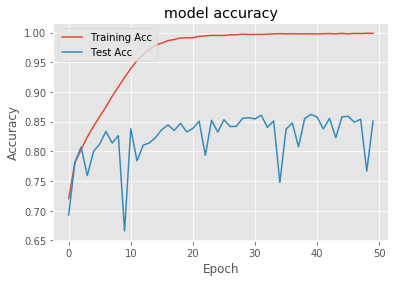

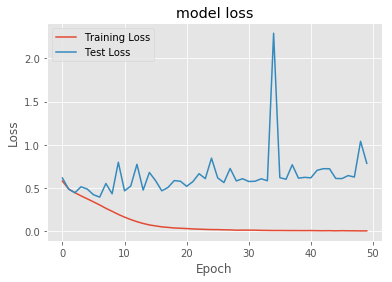

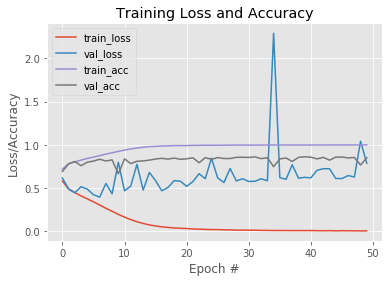

In [24]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [25]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.7734152045845986
Validation Accuracy:  0.85125


In [26]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

31/30 [==============================] - 2s 68ms/step
No of errors = 150/967


Confusion Matrix
[[623  32]
 [118 194]]


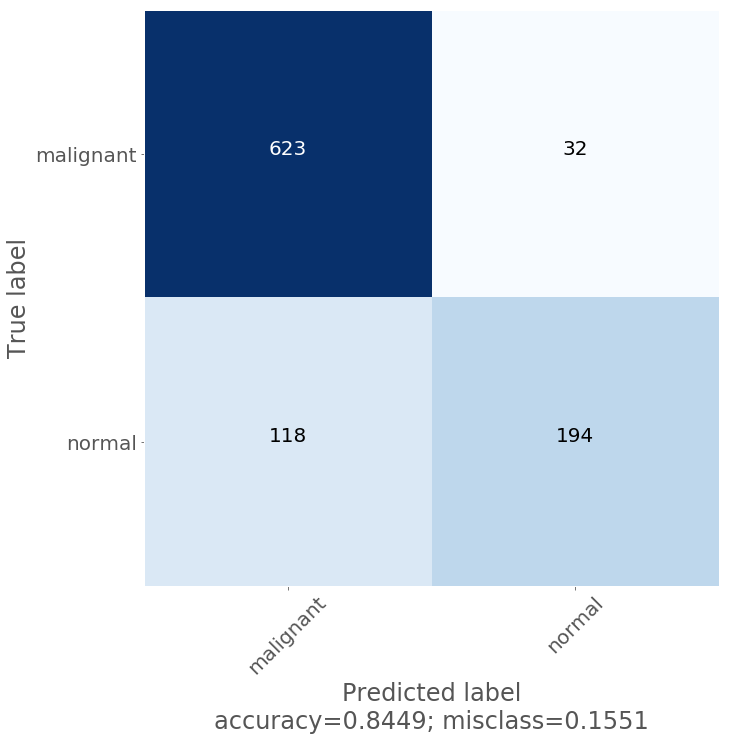

In [28]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[623  32]
 [118 194]]
              precision    recall  f1-score   support

   malignant       0.84      0.95      0.89       655
      normal       0.86      0.62      0.72       312

   micro avg       0.84      0.84      0.84       967
   macro avg       0.85      0.79      0.81       967
weighted avg       0.85      0.84      0.84       967



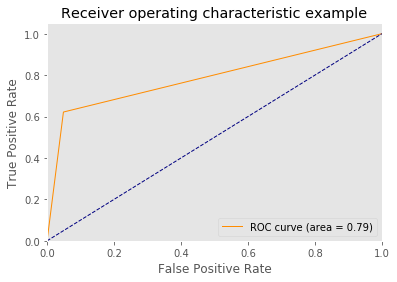

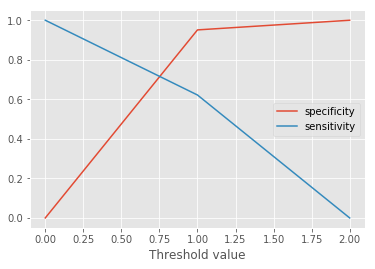

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()



In [ ]:
# model.save('models/6.ShuffleNet-ISIB19-Model.h5')
# model.save_weights('models/6.ShuffleNet-ISIB19-Weights.h5')

In [33]:
model.save('models/6.ShuffleNet-ISIB19-SGD_Model.h5')
model.save_weights('models/6.ShuffleNet-ISIB19-SGD-Weights.h5')